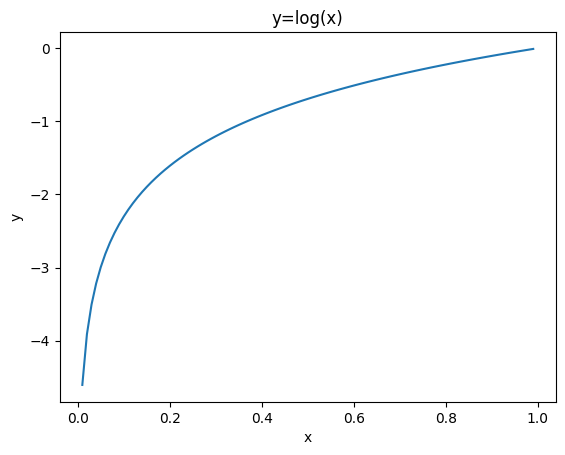

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0.01,1,0.01)
y = np.log(x)
plt.title("y=log(x)") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.plot(x,y)
plt.show()
plt.figure()

In [3]:
import paddle
from paddle.vision.transforms import Normalize

def get_MNIST_dataloader():
    transform = Normalize(mean=[127.5], std=[127.5],data_format='CHW')
    train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
    test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=1, drop_last=True)
    test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=1, drop_last=True)

    return train_loader, test_loader

In [4]:
train_loader, test_loader = get_MNIST_dataloader()

C:\Users\gudeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\paddle\fluid\reader.py:486: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


In [5]:
# 定义 SimpleNet 网络结构
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         return x

In [6]:
def evaluation(model, datasets):
    model.eval()

    acc_set = list()
    for batch_id, data in enumerate(datasets()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        pred = model(images)   # 获取预测值
        acc = paddle.metric.accuracy(input=pred, label=labels)
        acc_set.extend(acc.numpy())
    
    # #计算多个batch的准确率
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean

In [7]:
#仅修改计算损失的函数，从均方误差（常用于回归问题）到交叉熵误差（常用于分类问题）
def train(model):
    model.train()
    #调用加载数据的函数
    # train_loader = load_data('train')
    # val_loader = load_data('valid')
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，使用交叉熵损失函数，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
        # acc_train_mean = evaluation(model, train_loader)
        # acc_val_mean = evaluation(model, val_loader)
        # print('train_acc: {}, val acc: {}'.format(acc_train_mean, acc_val_mean))   
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

epoch: 0, batch: 0, loss is: [3.2759323]
epoch: 0, batch: 200, loss is: [0.28230175]
epoch: 0, batch: 400, loss is: [0.2081142]
epoch: 0, batch: 600, loss is: [0.15493906]
epoch: 0, batch: 800, loss is: [0.13768591]
epoch: 1, batch: 0, loss is: [0.14081122]
epoch: 1, batch: 200, loss is: [0.1584866]
epoch: 1, batch: 400, loss is: [0.06151015]
epoch: 1, batch: 600, loss is: [0.09166461]
epoch: 1, batch: 800, loss is: [0.10762259]
epoch: 2, batch: 0, loss is: [0.03520254]
epoch: 2, batch: 200, loss is: [0.04777319]
epoch: 2, batch: 400, loss is: [0.07391486]
epoch: 2, batch: 600, loss is: [0.16678208]
epoch: 2, batch: 800, loss is: [0.04580376]
epoch: 3, batch: 0, loss is: [0.17397878]
epoch: 3, batch: 200, loss is: [0.05423743]
epoch: 3, batch: 400, loss is: [0.09882441]
epoch: 3, batch: 600, loss is: [0.11440786]
epoch: 3, batch: 800, loss is: [0.09005695]
epoch: 4, batch: 0, loss is: [0.0718576]
epoch: 4, batch: 200, loss is: [0.10329691]
epoch: 4, batch: 400, loss is: [0.18485755]
ep

In [8]:
from PIL import Image

# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    # 图像归一化
    im = 1.0 - im / 255.
    return im

# 定义预测过程
model = MNIST()
params_file_path = 'mnist.pdparams'
img_path = 'work/example_0.jpg'
# 加载模型参数
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
# 灌入数据
model.eval()
tensor_img = load_image(img_path)
#模型反馈10个分类标签的对应概率
results = model(paddle.to_tensor(tensor_img))
#取概率最大的标签作为预测输出
lab = np.argsort(results.numpy())
print("本次预测的数字是: ", lab[0][-1])

本次预测的数字是:  0


C:\Users\gudeb\AppData\Local\Temp\ipykernel_16888\378201972.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((28, 28), Image.ANTIALIAS)
